In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
import matplotlib.pyplot as plt4
import seaborn as sns

In [2]:
#Dataframe creation from input datafile
def create_df(file):
    return pd.read_csv(file)

In [3]:
#Feature Selection
def reduce_features(df,reduced_features):
    return pd.DataFrame(df, columns = reduced_features)

In [4]:
#Converting String to integer values for benefit of logistic regression which requires numerical data
def map_race(df):
    mapping = {'African-American' : 0, 'Asian' : 1, 'Caucasian' : 2, 'Hispanic' : 3,'Native American' : 4, 'Other' : 5}
    return df.replace({'race' : mapping})

In [5]:
#Ground truth
def get_y_actual(df):
    return df['two_year_recid'].to_numpy()

In [6]:
#Array containing the races available in dataset
def unique_array_races(df):
    return np.unique(df['race'].to_numpy())

In [7]:
#Calculating race wise recidivism and no recidivism count. 
#Count for each race correspond indexes in array that were assigned in initial string to numerical reassign
def get_race_wise_count(df):
    race_recidivism_count = [0,0,0,0,0,0]
    race_norecidivism_count = [0,0,0,0,0,0]
    for i in range (len(df['race'])):
        if(df.iloc[i,-1] == 0):
            race_norecidivism_count[df['race'].iloc[i]] += 1
        else:
            race_recidivism_count[df['race'].iloc[i]] += 1
    return race_recidivism_count, race_norecidivism_count

In [34]:
def plot_rec_vs_nonrec_allrace(race_recidivism_count, race_nonrecidivism_count, race_array):
    w = 0.4
    bar1 = np.arange(6)
    bar2 = [i+w for i in bar1]
    plt3.bar(bar1,race_norecidivism_count,w,color = 'green',label = 'people not recidivated')
    plt3.bar(bar2,race_recidivism_count,w,color = 'red',label = 'people recidivated')
    plt3.title("Recidivated vs Not Recidivated for each race")
    plt3.xlabel('Race')
    plt3.ylabel('count')
#     plt3.xticks(bar1,race_array)
    plt3.legend()


In [9]:
#Calculating race wise decile score count
def get_race_wise_decile_count(df):
    decile_afam = df.loc[df['race'] == 0,'decile_score'].values
    decile_asian = df.loc[df['race'] == 1,'decile_score'].values
    decile_cau = df.loc[df['race'] == 2,'decile_score'].values
    decile_his = df.loc[df['race'] == 3,'decile_score'].values
    decile_nat = df.loc[df['race'] == 4,'decile_score'].values
    decile_oth = df.loc[df['race'] == 5,'decile_score'].values
    return decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth

In [10]:
def plot_histogram_decile_score_against_races(decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth):
    plt.rcParams["figure.figsize"] = (15,8)
    plt.hist([decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth],width = 0.15)
    plt.title("Histogram of distirbution of decile_score for each race")
    plt.xlabel('decile_score')
    plt.ylabel('count')
    plt.legend(['African-American','Asian','Caucasian','Hispanic','Native American','Other'])

In [11]:
def african_american_vs_caucasian_decile_score(decile_afam, decile_cau):
    plt2.rcParams["figure.figsize"] = (15,8)
    plt2.hist([decile_afam,decile_cau])
    plt2.title("Histogram of distirbution of decile_score African Americans vs Caucasians")
    plt2.xlabel('decile_score')
    plt2.ylabel('count')
    plt2.legend(['African-American','Caucasian'])

In [12]:
# Calculating accuracy of prediction.
# Note: Accuracy of the LR model is tested against Y_labels not against ground truth
def calculate_model_accuracy(pred, labels_test_arr):
    count = 0
    for i in range (len(pred)):
        if(pred[i] == labels_test_arr[i]):
            count+=1
    avg = (count/len(pred))*100
    return round(avg,2)

In [26]:
#Post prediction study vs Ground truth
#Calculating race wise false positives. Also for African american and Caucasians for Opprtunity cost /unsure/
def get_false_positives(df, pred, start_count, recid_status):
    false_positives = []
    af_am_fp = 0
    ca_fp = 0
    race_false_positives = [0,0,0,0,0,0]
    for i in range (len(pred)):
        if(pred[i] == 1 and recid_status[start_count+i] == 0):
            race_false_positives[df['race'].iloc[i]] += 1
            false_positives.append(df['race'].iloc[i])
            if(df['race'].iloc[i] == 0):
                af_am_fp += 1
            if(df['race'].iloc[i] == 2):
                ca_fp += 1
    return false_positives, af_am_fp, ca_fp, race_false_positives

In [14]:
def print_fp_ratio_by_races(false_positives, af_am_fp, ca_fp):
    if(len(false_positives) != 0):
        perc_af_am_fp = (af_am_fp / len(false_positives))*100
        perc_cauc_fp = (ca_fp / len(false_positives))*100
    print("Ratio of African americans in false positive: ",af_am_fp,"/",len(false_positives))
    print("Percentage: ",perc_af_am_fp)
    print("Ratio of Caucasians in false positive: ",ca_fp,"/",len(false_positives))
    print("Percentage: ",perc_cauc_fp)

In [15]:
# def plot_fp_vs_race(race_false_positives):
#     plt.rcParams["figure.figsize"] = (8,4.5)
#     plt.bar(race_false_positives)
#     plt.title("False positive count for each race")

In [16]:
# Accuracy of prediction vs ground Truth
def get_confusion_matrix_values(pred, start_count, recid_status):
    fp = 0; fn = 0; tp = 0; tn = 0;
    for i in range (len(pred)):
        if(pred[i] == 1 and recid_status[start_count+i] == 0):
            fp += 1
        if(pred[i] == 0 and recid_status[start_count+i] == 1):
            fn += 1
        if(pred[i] == 1 and recid_status[start_count+i] == 1):
            tp += 1
        if(pred[i] == 0 and recid_status[start_count+i] == 0):
            tn += 1
    return fp, fn, tp, tn

In [17]:
def plot_pred_vs_actual(fp, fn, tp, tn):
    plt4.bar(['fp','fn','tp','tn'],[fp,fn,tp,tn])
    plt4.title("Prediction vs Actual")
    plt4.xlabel('accuracy status')
    plt4.ylabel('count')

In [18]:
def print_stats(fp, fn, tp, tn, pred):
    fp_p = (fp/(tn+fp))*100
    fn_p = (fn/(tp+fn))*100
    tp_p = (tp/len(pred))*100
    tn_p = (tn/len(pred))*100
    acc = ((tp+tn)/len(pred))*100
    #False positive rate
    print("False positive: ",fp)
    print("False positive rate: ",round(fp_p,2),"%")
    #False Negative
    print("False Negative: ",fn)
    print("False Negative rate: ",round(fn_p,2),"%")
    #True positive
    print("True positive: ", tp)
    print("True positive percentage: ",round(tp_p,2),"%")
    print("Positive predicted value: ", round(tp/(tp+fp)*100,2), "%")
    #True negative
    print("True negative: ", tn)
    print("True negative percentage: ",round(tn_p,2),"%")
    print("Negative predicted value: ", round(tn/(tn+fn)*100,2), "%")
    #Accuracy
    print("Accuracy: ",round((tp+tn)/len(pred)*100,2),"%")

Init

In [19]:
reduced_features = ['age','race','juv_fel_count','juv_misd_count','juv_other_count','priors_count','is_violent_recid','decile_score','v_decile_score','priors_count','start','end','event', 'two_year_recid', 'labels']

In [20]:
file = "compas-scores-two-years1.csv"

In [21]:
df = create_df(file)

In [22]:
df_with_reduced_features = reduce_features(df,reduced_features)

In [23]:
df_post_mapping = map_race(df_with_reduced_features)

Executing Logistic Regression by making equal population of Caucasian and African Americans in the input dataset

In [29]:
Afam_Dataframe_norec = df_post_mapping[(df_post_mapping['race'] == 0) & (df_post_mapping['two_year_recid'] == 0)]
Afam_Dataframe_rec = df_post_mapping[(df_post_mapping['race'] == 0) & (df_post_mapping['two_year_recid'] == 1)]
Cau_Dataframe_norec = df_post_mapping[(df_post_mapping['race'] == 2) & (df_post_mapping['two_year_recid'] == 0)]
Cau_Dataframe_rec = df_post_mapping[(df_post_mapping['race'] == 2) & (df_post_mapping['two_year_recid'] == 1)]
print(Afam_Dataframe_norec.shape,Afam_Dataframe_rec.shape,Cau_Dataframe_norec.shape,Cau_Dataframe_rec.shape)
Afam_Dataframe_norec_t = Afam_Dataframe_norec.sample(n=966)
Afam_Dataframe_rec_t = Afam_Dataframe_rec.sample(n=966)
Cau_Dataframe_norec_t = Cau_Dataframe_norec.sample(n=966)
Cau_Dataframe_rec_t = Cau_Dataframe_rec.sample(n=966)
Equalized_Dataframe = pd.concat([Afam_Dataframe_norec_t,Afam_Dataframe_rec_t,Cau_Dataframe_norec_t,Cau_Dataframe_rec_t],axis = 0)
Equalized_Dataframe.to_csv("COMPAS_equal_dist.csv")


(1795, 15) (1901, 15) (1488, 15) (966, 15)


Without protected and all records

Accuracy of model:  94.37 %
Ratio of African americans in false positive:  210 / 410
Percentage:  51.21951219512195
Ratio of Caucasians in false positive:  140 / 410
Percentage:  34.146341463414636
False positive:  410
False positive rate:  31.73 %
False positive:  361
False positive rate:  33.15 %
True positive:  728
True positive percentage:  30.58 %
Positive predicted value:  63.97 %
True negative:  882
True negative percentage:  37.04 %
Negative predicted value:  70.96 %
Accuracy:  67.62 %


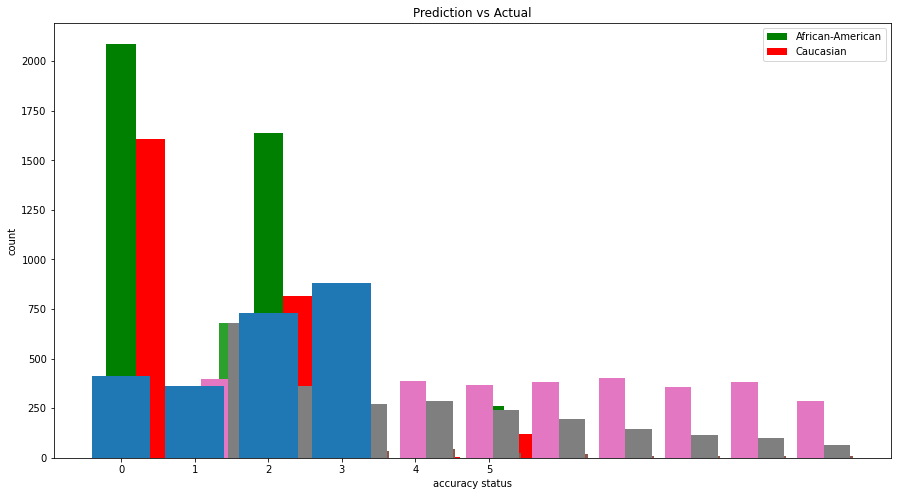

In [27]:
#Output labels
y_labels = df_post_mapping['labels']
#y actual
y_actual = get_y_actual(df_post_mapping)
#deleting actaul values and labels
df_with_x = df_post_mapping.copy()
df_with_x.drop('labels', inplace=True, axis=1)
df_with_x.drop('two_year_recid', inplace=True, axis=1)

#array containing races
races_array = unique_array_races(df_with_x)

#get race wise count
race_recidivism_count, race_norecidivism_count = get_race_wise_count(df_with_x)
#plot rec vs non rec against each race
plot_rec_vs_nonrec_allrace(race_recidivism_count, race_norecidivism_count, races_array)

#get race wise decile scores
decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth = get_race_wise_decile_count(df_with_x)
#plot histogram
plot_histogram_decile_score_against_races(decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth)

#af-american decile score vs cau decile score
african_american_vs_caucasian_decile_score(decile_afam, decile_cau)

# Train test split. Train : 2/3 of total dataset
data_train,data_test,labels_train,labels_test = train_test_split(df_with_x, y_labels,test_size = 0.33,random_state = 42,shuffle=False)

# Training model using logistic regression
import warnings
warnings.filterwarnings('ignore')
lr = LogisticRegression()
lr.fit(data_train,labels_train)

# Predicting for test labels
pred = lr.predict(data_test)

labels_test_arr = labels_test.values

#model accuracy
accuracy = calculate_model_accuracy(pred, labels_test_arr)
print("Accuracy of model: ",accuracy, "%")

false_positives, af_am_fp, ca_fp, race_false_positives = get_false_positives(df_with_x, pred, len(data_train), y_actual)
print_fp_ratio_by_races(false_positives, af_am_fp, ca_fp)
# plot_fp_vs_race(race_false_positives)

fp, fn, tp, tn = get_confusion_matrix_values(pred, len(data_train), y_actual)

plot_pred_vs_actual(fp, fn, tp, tn)

print_stats(fp, fn, tp, tn, pred)


Without protected and Equal population records in Logistic Regression

[821, 0, 800, 0, 0, 0]
Accuracy of model:  65.52 %
Ratio of African americans in false positive:  32 / 32
Percentage:  100.0
Ratio of Caucasians in false positive:  0 / 32
Percentage:  0.0
False positive:  32
False positive rate:  10.32 %
False positive:  332
False positive rate:  34.37 %
True positive:  634
True positive percentage:  49.69 %
Positive predicted value:  95.2 %
True negative:  278
True negative percentage:  21.79 %
Negative predicted value:  45.57 %
Accuracy:  71.47 %


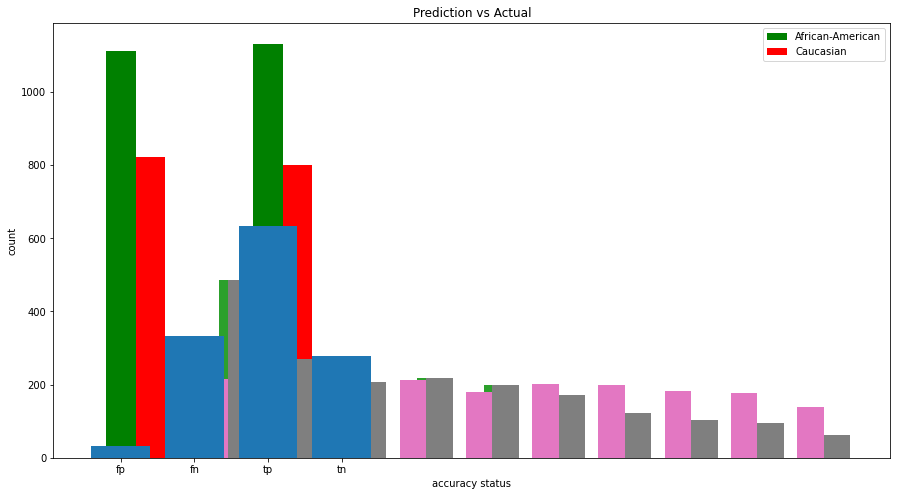

In [62]:
#Output labels
y_labels = Equalized_Dataframe['labels']
#y actual
y_actual = get_y_actual(Equalized_Dataframe)
#deleting actaul values and labels
df_with_x = Equalized_Dataframe.copy()
df_with_x.drop('labels', inplace=True, axis=1)
df_with_x.drop('two_year_recid', inplace=True, axis=1)

#array containing races
races_array = unique_array_races(df_with_x)

#get race wise count
race_recidivism_count, race_norecidivism_count = get_race_wise_count(df_with_x)
print(race_recidivism_count)
#plot rec vs non rec against each race
plot_rec_vs_nonrec_allrace(race_recidivism_count, race_norecidivism_count, races_array)

#get race wise decile scores
decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth = get_race_wise_decile_count(df_with_x)
#plot histogram
plot_histogram_decile_score_against_races(decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth)

#af-american decile score vs cau decile score
african_american_vs_caucasian_decile_score(decile_afam, decile_cau)


df_without_race = df_with_x.copy()
df_without_race.drop('race', inplace=True, axis=1)
df_without_race.drop('age', inplace=True, axis=1)
df_without_race.drop('decile_score', inplace=True, axis=1)
df_without_race.drop('v_decile_score', inplace=True, axis=1)
# df_without_race.drop('priors_count', inplace=True, axis=1)

data_train,data_test,labels_train,labels_test = train_test_split(df_without_race, y_labels,test_size = 0.33,random_state = 42,shuffle=False)

# Train test split. Train : 2/3 of total dataset
# data_train,data_test,labels_train,labels_test = train_test_split(df_with_x, y_labels,test_size = 0.33,random_state = 42,shuffle=False)

# Training model using logistic regression
import warnings
warnings.filterwarnings('ignore')
lr = LogisticRegression()
lr.fit(data_train,labels_train)

# Predicting for test labels
pred = lr.predict(data_test)

labels_test_arr = labels_test.values

#model accuracy
accuracy = calculate_model_accuracy(pred, labels_test_arr)
print("Accuracy of model: ",accuracy, "%")

false_positives, af_am_fp, ca_fp, race_false_positives = get_false_positives(df_with_x, pred, len(data_train), y_actual)
print_fp_ratio_by_races(false_positives, af_am_fp, ca_fp)
# plot_fp_vs_race(race_false_positives)

fp, fn, tp, tn = get_confusion_matrix_values(pred, len(data_train), y_actual)

plot_pred_vs_actual(fp, fn, tp, tn)

print_stats(fp, fn, tp, tn, pred)


Without protected and Equal population records in Decision Tree

Accuracy of model:  100.0 %
Ratio of African americans in false positive:  71 / 71
Percentage:  100.0
Ratio of Caucasians in false positive:  0 / 71
Percentage:  0.0
False positive:  71
False positive rate:  22.9 %
False positive:  461
False positive rate:  47.72 %
True positive:  505
True positive percentage:  39.58 %
Positive predicted value:  87.67 %
True negative:  239
True negative percentage:  18.73 %
Negative predicted value:  34.14 %
Accuracy:  58.31 %


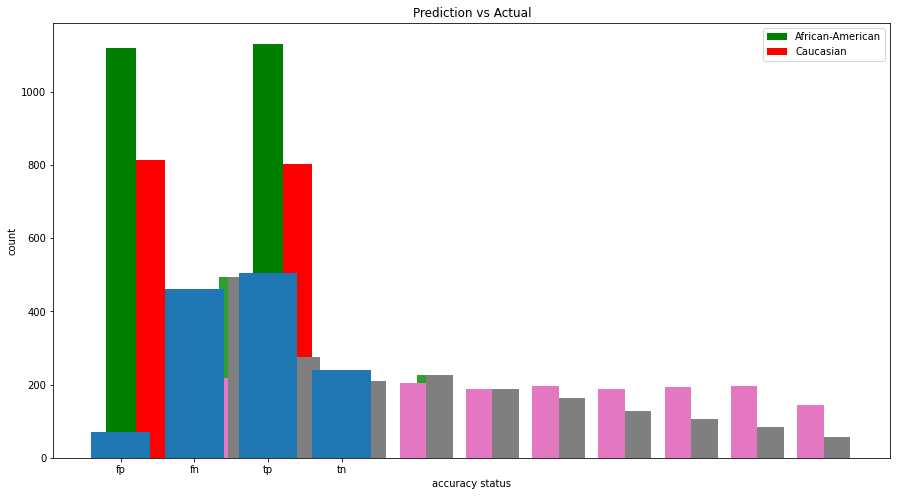

In [36]:
#Output labels
y_labels = Equalized_Dataframe['labels']
#y actual
y_actual = get_y_actual(Equalized_Dataframe)
#deleting actaul values and labels
df_with_x = Equalized_Dataframe.copy()
df_with_x.drop('labels', inplace=True, axis=1)
df_with_x.drop('two_year_recid', inplace=True, axis=1)

#array containing races
races_array = unique_array_races(df_with_x)

#get race wise count
race_recidivism_count, race_norecidivism_count = get_race_wise_count(df_with_x)

#plot rec vs non rec against each race
plot_rec_vs_nonrec_allrace(race_recidivism_count, race_norecidivism_count, races_array)

#get race wise decile scores
decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth = get_race_wise_decile_count(df_with_x)
#plot histogram
plot_histogram_decile_score_against_races(decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth)

#af-american decile score vs cau decile score
african_american_vs_caucasian_decile_score(decile_afam, decile_cau)

# Train test split. Train : 2/3 of total dataset
data_train,data_test,labels_train,labels_test = train_test_split(df_with_x, y_labels,test_size = 0.33,random_state = 42,shuffle=False)

# Training model using logistic regression
import warnings
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
decision_tree = DecisionTreeClassifier(max_depth=7, random_state=123)
decision_tree.fit(data_train,labels_train)

# Predicting for test labels
pred = decision_tree.predict(data_test)

labels_test_arr = labels_test.values

#model accuracy
accuracy = calculate_model_accuracy(pred, labels_test_arr)
print("Accuracy of model: ",accuracy, "%")

false_positives, af_am_fp, ca_fp, race_false_positives = get_false_positives(df_with_x, pred, len(data_train), y_actual)
print_fp_ratio_by_races(false_positives, af_am_fp, ca_fp)
# plot_fp_vs_race(race_false_positives)

fp, fn, tp, tn = get_confusion_matrix_values(pred, len(data_train), y_actual)

plot_pred_vs_actual(fp, fn, tp, tn)

print_stats(fp, fn, tp, tn, pred)


Without protected and Equal population records in Decision Forest

Accuracy of model:  100.0 %
Ratio of African americans in false positive:  71 / 71
Percentage:  100.0
Ratio of Caucasians in false positive:  0 / 71
Percentage:  0.0
False positive:  71
False positive rate:  22.9 %
False positive:  461
False positive rate:  47.72 %
True positive:  505
True positive percentage:  39.58 %
Positive predicted value:  87.67 %
True negative:  239
True negative percentage:  18.73 %
Negative predicted value:  34.14 %
Accuracy:  58.31 %


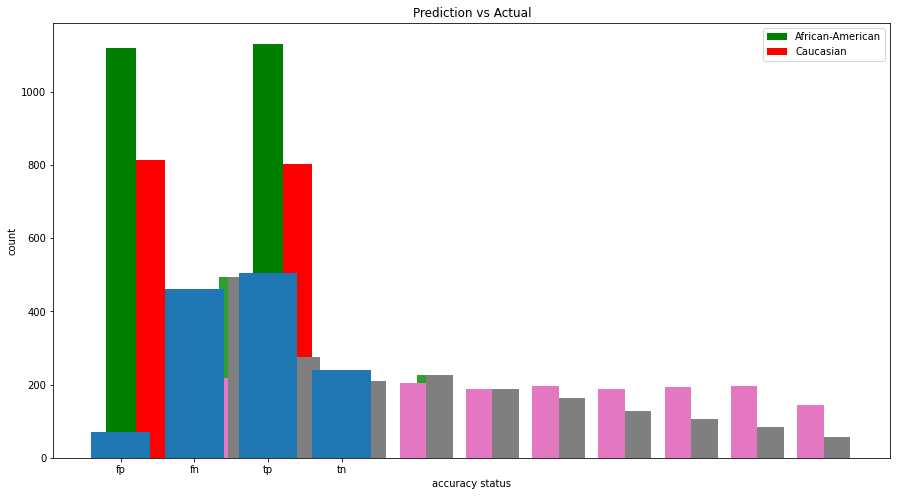

In [37]:
#Output labels
y_labels = Equalized_Dataframe['labels']
#y actual
y_actual = get_y_actual(Equalized_Dataframe)
#deleting actaul values and labels
df_with_x = Equalized_Dataframe.copy()
df_with_x.drop('labels', inplace=True, axis=1)
df_with_x.drop('two_year_recid', inplace=True, axis=1)

#array containing races
races_array = unique_array_races(df_with_x)

#get race wise count
race_recidivism_count, race_norecidivism_count = get_race_wise_count(df_with_x)

#plot rec vs non rec against each race
plot_rec_vs_nonrec_allrace(race_recidivism_count, race_norecidivism_count, races_array)

#get race wise decile scores
decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth = get_race_wise_decile_count(df_with_x)
#plot histogram
plot_histogram_decile_score_against_races(decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth)

#af-american decile score vs cau decile score
african_american_vs_caucasian_decile_score(decile_afam, decile_cau)

# Train test split. Train : 2/3 of total dataset
data_train,data_test,labels_train,labels_test = train_test_split(df_with_x, y_labels,test_size = 0.33,random_state = 42,shuffle=False)

# Training model using logistic regression
import warnings
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
decision_forest = RandomForestClassifier(max_depth=7, random_state=123)
decision_forest.fit(data_train,labels_train)

# Predicting for test labels
pred = decision_forest.predict(data_test)

labels_test_arr = labels_test.values

#model accuracy
accuracy = calculate_model_accuracy(pred, labels_test_arr)
print("Accuracy of model: ",accuracy, "%")

false_positives, af_am_fp, ca_fp, race_false_positives = get_false_positives(df_with_x, pred, len(data_train), y_actual)
print_fp_ratio_by_races(false_positives, af_am_fp, ca_fp)
# plot_fp_vs_race(race_false_positives)

fp, fn, tp, tn = get_confusion_matrix_values(pred, len(data_train), y_actual)

plot_pred_vs_actual(fp, fn, tp, tn)

print_stats(fp, fn, tp, tn, pred)


With Protected and LR

Accuracy of model:  66.69 %
Ratio of African americans in false positive:  74 / 153
Percentage:  48.36601307189542
Ratio of Caucasians in false positive:  50 / 153
Percentage:  32.6797385620915
False positive:  153
False positive rate:  11.84 %
False positive:  233
False positive rate:  21.4 %
True positive:  856
True positive percentage:  35.95 %
Positive predicted value:  84.84 %
True negative:  1139
True negative percentage:  47.84 %
Negative predicted value:  83.02 %
Accuracy:  83.79 %


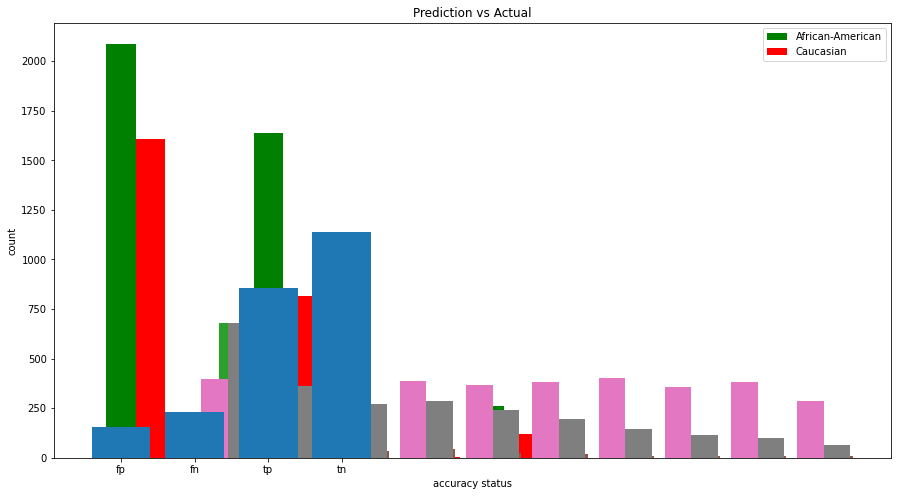

In [76]:
reduced_features = ['age','race','juv_fel_count','juv_misd_count','juv_other_count','priors_count','is_violent_recid','decile_score','v_decile_score','start','end','event', 'two_year_recid', 'labels']
file = "compas-scores-two-years1.csv"
df = create_df(file)
df_with_reduced_features = reduce_features(df,reduced_features)
df_post_mapping = map_race(df_with_reduced_features)

# Afam_Dataframe_norec = df_post_mapping[(df_post_mapping['race'] == 0) & (df_post_mapping['two_year_recid'] == 0)]
# Afam_Dataframe_rec = df_post_mapping[(df_post_mapping['race'] == 0) & (df_post_mapping['two_year_recid'] == 1)]
# Cau_Dataframe_norec = df_post_mapping[(df_post_mapping['race'] == 2) & (df_post_mapping['two_year_recid'] == 0)]
# Cau_Dataframe_rec = df_post_mapping[(df_post_mapping['race'] == 2) & (df_post_mapping['two_year_recid'] == 1)]
# print(Afam_Dataframe_norec.shape,Afam_Dataframe_rec.shape,Cau_Dataframe_norec.shape,Cau_Dataframe_rec.shape)
# Afam_Dataframe_norec_t = Afam_Dataframe_norec.sample(n=966)
# Afam_Dataframe_rec_t = Afam_Dataframe_rec.sample(n=966)
# Cau_Dataframe_norec_t = Cau_Dataframe_norec.sample(n=966)
# Cau_Dataframe_rec_t = Cau_Dataframe_rec.sample(n=966)
# Equalized_Dataframe = pd.concat([Afam_Dataframe_norec_t,Afam_Dataframe_rec_t,Cau_Dataframe_norec_t,Cau_Dataframe_rec_t],axis = 0)
# # Equalized_Dataframe.to_csv("COMPAS_equal_dist.csv")


#Output labels
y_labels = df_post_mapping['labels']
#y actual
y_actual = get_y_actual(df_post_mapping)
#deleting actaul values and labels
df_with_x = df_post_mapping.copy()
df_with_x.drop('labels', inplace=True, axis=1)
df_with_x.drop('two_year_recid', inplace=True, axis=1)

#array containing races
races_array = unique_array_races(df_with_x)

#get race wise count
race_recidivism_count, race_norecidivism_count = get_race_wise_count(df_with_x)
#plot rec vs non rec against each race
plot_rec_vs_nonrec_allrace(race_recidivism_count, race_norecidivism_count, races_array)

#get race wise decile scores
decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth = get_race_wise_decile_count(df_with_x)
#plot histogram
plot_histogram_decile_score_against_races(decile_afam, decile_asian, decile_cau, decile_his, decile_nat, decile_oth)

#af-american decile score vs cau decile score
african_american_vs_caucasian_decile_score(decile_afam, decile_cau)

# Train test split. Train : 2/3 of total dataset
df_without_race = df_with_x.copy()
df_without_race.drop('race', inplace=True, axis=1)
df_without_race.drop('age', inplace=True, axis=1)
df_without_race.drop('decile_score', inplace=True, axis=1)
df_without_race.drop('v_decile_score', inplace=True, axis=1)
df_without_race.drop('priors_count', inplace=True, axis=1)
data_train,data_test,labels_train,labels_test = train_test_split(df_without_race, y_labels,test_size = 0.33,random_state = 42,shuffle=False)

# Training model using logistic regression
import warnings
warnings.filterwarnings('ignore')

import warnings
from sklearn.tree import DecisionTreeClassifier

lr = LogisticRegression()
lr.fit(data_train,labels_train)

# Predicting for test labels
pred = lr.predict(data_test)

labels_test_arr = labels_test.values

#model accuracy
accuracy = calculate_model_accuracy(pred, labels_test_arr)
print("Accuracy of model: ",accuracy, "%")

false_positives, af_am_fp, ca_fp, race_false_positives = get_false_positives(df_with_x, pred, len(data_train), y_actual)
print_fp_ratio_by_races(false_positives, af_am_fp, ca_fp)
# plot_fp_vs_race(race_false_positives)

fp, fn, tp, tn = get_confusion_matrix_values(pred, len(data_train), y_actual)

plot_pred_vs_actual(fp, fn, tp, tn)

print_stats(fp, fn, tp, tn, pred)
